# Analysis code

Code for stats + figures.

Run this notebook from the `scripts` folder. Before running, ensure all default
values have been populated with `./scripts/update_param_list_in_model_yaml.sh`.

## Preamble (always run)

In [1]:
# for plotting
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [24]:
# imports
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import pingouin as pg
import statsmodels as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

sns.set_theme('paper', font_scale=2)

%aimport exp_utils
from exp_utils import *

WIDTHS = (2, 4, 8, 16, 32, 64, 128)
STEPS = (1, 3, 6, 12, 24)

## ZeroSpeech libriABX analysis

In [3]:
# load zrc data
dfz = collate_data()
dfz.head(10)

,zrc.subset,zrc.speaker_mode,zrc.context_mode,zrc.granularity,zrc.score,zrc.pooling,zrc.seed,zrc.pca_style,name,feat_type,...,training.cpc_loss.prediction_steps,training.cpc_loss.gutted_steps,training.cpc_loss.negative_samples,training.cpc_loss.offset,training.cpc_loss.prediction_type,training.cpc_loss.averaging_penalty,training.cpc_loss.prediction_dropout_prob,training.shuffle,training.max_epochs,training.early_stopping_patience
0,dev-clean,within,within,triphone,0.1352,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
1,dev-clean,across,within,triphone,0.1860,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
2,dev-other,within,within,triphone,0.1550,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
3,dev-other,across,within,triphone,0.2382,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
4,test-clean,within,within,triphone,0.1283,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
5,test-clean,across,within,triphone,0.1696,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
6,test-other,within,within,triphone,0.1546,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
7,test-other,across,within,triphone,0.2440,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
8,dev-clean,within,within,phoneme,0.0767,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10
9,dev-clean,across,within,phoneme,0.1148,none,3459,full,cpc.csa128/version_0012,raw,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,500,10


In [21]:
# determine significance of context windows

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "training.max_epochs": 200,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.context_mode"
)

# 5 seeds * 7 context widths * 2 context modes * 4 partitions
assert len(df) == 5 * 7 * 2 * 4

df = df[['name', 'csa.max_width', 'zrc.score']].groupby('name', as_index=False, observed=True, sort=True).mean(numeric_only=True)
df['csa.max_width'] = df['csa.max_width'].astype('int').astype('category')

pg.print_table(pg.anova(data=df, dv='zrc.score', between='csa.max_width'))
pg.print_table(pg.normality(data=df, dv='zrc.score', group='csa.max_width'))
pg.print_table(pg.homoscedasticity(data=df, dv='zrc.score', group='csa.max_width'))

pg.print_table(pg.pairwise_tests(data=df, dv='zrc.score', between='csa.max_width', parametric=False, return_desc=True))



ANOVA SUMMARY

Source           ddof1    ddof2      F    p-unc    np2
-------------  -------  -------  -----  -------  -----
csa.max_width        6       28  5.876    0.000  0.557

    W    pval  normal
-----  ------  --------
0.861   0.232  True
0.922   0.542  True
0.854   0.207  True
0.893   0.372  True
0.950   0.734  True
0.924   0.555  True
0.967   0.853  True

    W    pval  equal_var
-----  ------  -----------
0.855   0.539  True


POST HOC TESTS

Contrast         A    B    mean(A)    std(A)    mean(B)    std(B)  Paired    Parametric      U-val  alternative      p-unc    hedges
-------------  ---  ---  ---------  --------  ---------  --------  --------  ------------  -------  -------------  -------  --------
csa.max_width    2    4      0.136     0.003      0.122     0.014  False     False          20.000  two-sided        0.151     1.224
csa.max_width    2    8      0.136     0.003      0.135     0.013  False     False          12.000  two-sided        1.000     0.099
csa.max_w

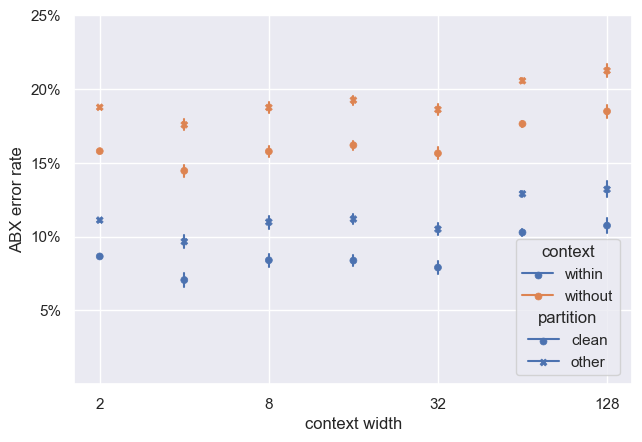

In [44]:
# plot libriABX scores across subsets and context windows w/ phoneme granularity

fig = plt.figure(1, figsize=[6.8, 4.8])
# # cpc.small results
# df = filter_data_equal(dfz, {
#     'name': 'cpc.small/version_2',
#     "zrc.pca_style": "full",
#     "zrc.speaker_mode": "within",
#     "zrc.granularity": "phoneme",
# }).copy()
# df['zrc.subset'] = df['zrc.subset'].map(
#     {
#         'test-clean': 'clean',
#         'test-other': 'other',
#         'dev-clean': 'clean',
#         'dev-other': 'other'}
# )
# df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})
# df = (
#     df[['zrc.context_mode', 'zrc.subset', 'zrc.score']]
#     .groupby(['zrc.context_mode', 'zrc.subset']).mean()
# )
# ax.axhline(y=df.loc[('within', 'clean'), 'zrc.score'], color=sns.color_palette()[0], linestyle='--', alpha=0.75)
# ax.axhline(y=df.loc[('without', 'clean'), 'zrc.score'], color=sns.color_palette()[1], linestyle='--', alpha=0.75)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "training.max_epochs": 200,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode"
)

# 5 seeds * 7 context widths * 2 context modes * 4 partitions
assert len(df) == 5 * 7 * 2 * 4

# aggregate dev and test into their quality
df['zrc.subset'] = df['zrc.subset'].map(
    {
        'test-clean': 'clean',
        'test-other': 'other',
        'dev-clean': 'clean',
        'dev-other': 'other'}
)
df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})

# ensure each point in a vertical slice gets its own error bar
df['zrc.sbyc'] = df.agg("{0[zrc.subset]}-{0[zrc.context_mode]}".format, axis=1)

plot = (
    so.Plot(df, x="csa.max_width", y="zrc.score", color="zrc.context_mode", marker="zrc.subset")
    .limit(y=(0.00, 0.25))
    .add(so.Dot(pointsize=5), so.Agg())
    .add(so.Range(), so.Est(errorbar="se"), group='zrc.sbyc')  # 1 standard error
    # .add(so.Line(marker=None), so.PolyFit())  # misleading?
    .scale(
        x=(
            so.Continuous(trans="log")
            .tick(at=[2, 8, 32, 128])
            .label(like='d', base=2)
        ),
        y=(
            so.Continuous()
            .tick(at=[0.05, 0.1, 0.15, 0.2, 0.25])
            .label(like='.0%')
        ),
    )
    .label(x="context width", y="ABX error rate", color="context", marker="partition")
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .325
bb.y0 -= .725
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/libriabx_context_subset_phoneme.pdf')

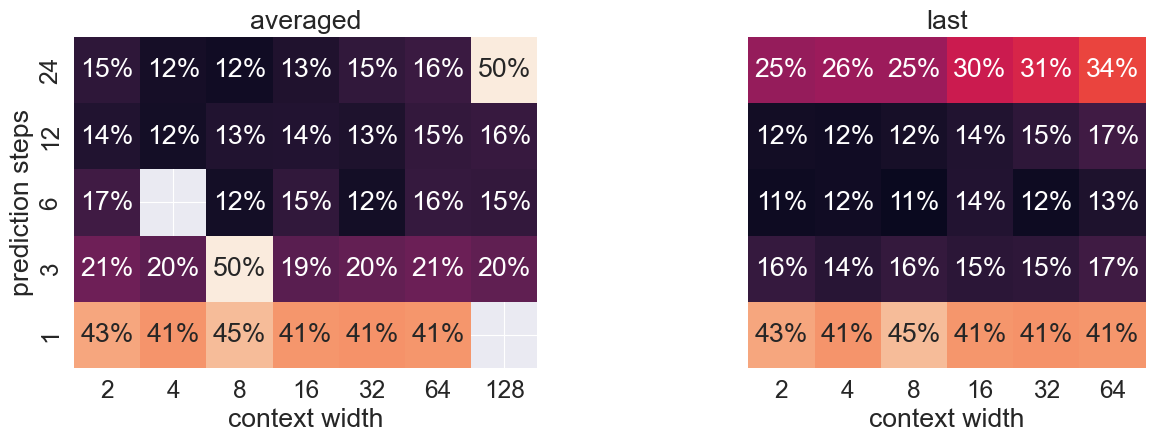

In [26]:
# plot libriABX score of context width vs prediction steps (averaged)
# - this one will show up on the left of our figure, so it doesn't have the cbar
#   but does have the y axis label
fig, axs = plt.subplots(1, 2, figsize=(14, 4.8), sharey=True)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
    "training.max_epochs": 200,
})
df = filter_data_in(
    df, {
        "csa.max_width": WIDTHS,
        "training.cpc_loss.prediction_steps": range(1, 25),
    }
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode",
    "training.cpc_loss.prediction_steps"
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.1, vmax=0.5, cbar=False, square=True, ax=axs[0])
plot.set(xlabel='context width', ylabel='prediction steps', title='averaged')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.negative_samples": 128,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {"csa.max_width": range(2, 65)}
)
idx = df['training.cpc_loss.prediction_steps'] == 1
for n in range(2, 25):
    idx |= (df['training.cpc_loss.prediction_steps'] == n) & (df['training.cpc_loss.gutted_steps'] == (n - 1))
df = df.loc[idx]
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.gutted_steps",
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.1, vmax=0.5, square=True, cbar=False, ax=axs[1])
plot.set(xlabel='context width', ylabel=None, title='last')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])
plot.set_yticklabels([f'{int(x):d}' for x in sorted(df.index, reverse=True)])

fig.tight_layout()
fig.savefig("../resources/libriabx_prediction_steps_vs_width.pdf")

In [30]:
# various means for stats table
# (main can be derived from the above figure)

row2names = {
    "main":  set(f'cpc.csa{w}/version_{v:04d}' for w in WIDTHS for v in range(101, 106)),
    "long train": set(f'cpc.csa{w}/version_0012' for w in WIDTHS),
    "960h": set(f'cpc.csa{w}/version_0003' for w in WIDTHS),
    "2-layer": set(f'cpc.csa{w}/version_1001' for w in WIDTHS),
    "4-layer": set(f'cpc.csa{w}/version_1101' for w in WIDTHS),
    "conv (fixed size)": set(f"cpc.cconv{w}/version_0101" for w in WIDTHS),
    "conv (fixed H_2)": set(f"cpc.cconv{w}/version_0201" for w in WIDTHS),
    "BEST-RQ": set(f"bestrq.csa{w}" for w in WIDTHS),
}
name2row = dict()
for row, names in row2names.items():
    name2row.update((name, row) for name in names)

df = filter_data_equal(dfz, {"zrc.speaker_mode": "within", "zrc.granularity": "phoneme"})
df = filter_data_in(df, {'name': set(name2row)}).copy()

df['csa.max_width'] = df['csa.max_width'].astype('int') #.where(~df['csa.max_width'].isna(), df['cconv.kernel_size']).astype('int')

df['name'] = df['name'].cat.remove_unused_categories().apply(lambda x: name2row[x])

df = pd.pivot_table(df, values='zrc.score', columns='csa.max_width', index='name')

(df * 100).style.format(precision=1)

csa.max_width,2,4,8,16,32,64,128
name,,,,,,,
long train,11.1,10.8,12.2,12.9,12.7,13.1,13.0
main,13.6,12.2,13.5,13.7,13.2,15.3,15.9


In [8]:
# the mean abx error rates for the models we trained downstream ASR systems for

assert False  # FIXME

df = filter_data_equal(dfz, {"zrc.speaker_mode": "within", "zrc.granularity": "phoneme"})
df = filter_data_in(df, {'name': {
    'cpc.trans2/version_1', 'cpc.trans4/version_1',
    'cpc.trans8/version_2', 'cpc.trans64/version_2',
}})
df['csa.max_width'] = df['csa.max_width'].astype('int')
df = pd.pivot_table(df, values='zrc.score', index='csa.max_width')
(df * 100).style.format(precision=1)

,zrc.score
csa.max_width,
2,12.5
4,11.9
8,11.5
64,16.7


## Tensorboard analysis

In [31]:
# load data
dft = collate_data("tb")
dft.head(10)

,tb.step,tb.epoch,tb.val_loss,name,feat_type,train_part,input_size,latent_type,context_type,version,...,training.cpc_loss.prediction_steps,training.cpc_loss.gutted_steps,training.cpc_loss.negative_samples,training.cpc_loss.offset,training.cpc_loss.prediction_type,training.cpc_loss.averaging_penalty,training.cpc_loss.prediction_dropout_prob,training.shuffle,training.max_epochs,training.early_stopping_patience
0,22960,0,3.177883,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
1,45921,1,2.824112,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
2,68882,2,2.735160,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
3,91843,3,2.654848,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
4,114804,4,2.582539,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
5,137765,5,2.516442,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
6,160726,6,2.454598,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
7,183687,7,2.397733,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
8,206648,8,2.357284,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10
9,229609,9,2.336003,cpc.csa128/version_0003,raw,960,1,conv,csa,3,...,12.0,0.0,128.0,0.0,csa,0.0,0.0,False,100,10


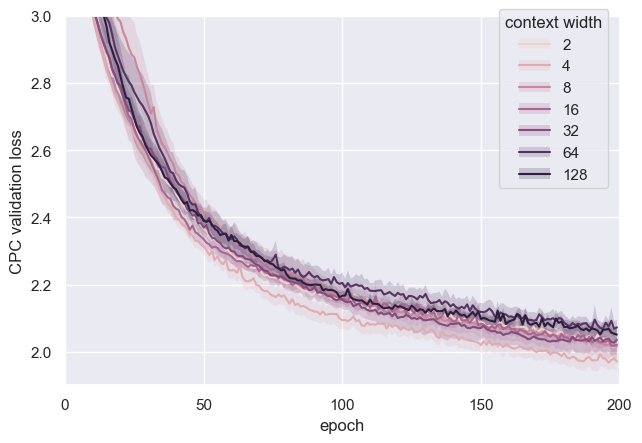

In [34]:
# regular training

df = filter_data_equal(dft, {
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.prediction_steps": 12,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "training.max_epochs": 200,
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
).copy()

check_data(
    df, "tb.epoch", "tb.val_loss", "tb.step", "csa.max_width"
)
# 5 seeds * 7 context windows
assert len(pd.unique(df['name'])) == 5 * 7

fig = plt.figure(1, figsize=[6.8, 4.8])
plot = (
    so.Plot(df, x="tb.epoch", y="tb.val_loss", color="csa.max_width")
    .limit(y=(1.9, 3.0), x=(0, 200))
    .add(so.Line(), so.Agg())
    .add(so.Band(), so.Est(errorbar="se"), group="csa.max_width")
    .label(x="epoch", y="CPC validation loss", color="context width")
    .scale(
        color=so.Continuous(trans="log")
            .tick(at=(2, 4, 8, 16, 32, 64, 128))
            .label(like=".0f"))
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .335
bb.y0 += .41
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/train_loss_vs_width.pdf')

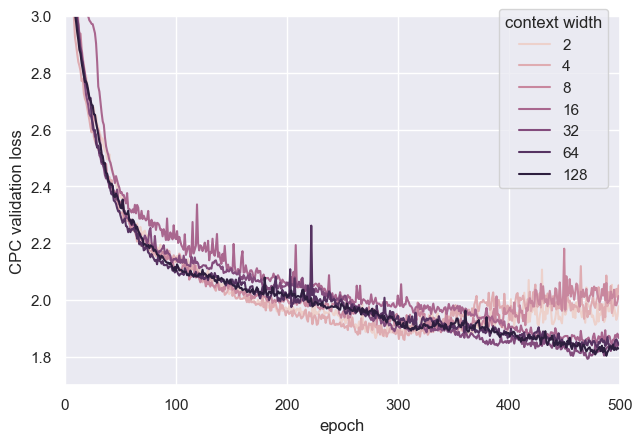

In [39]:
# long training

# regular training

df = filter_data_equal(dft, {
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.prediction_steps": 12,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "training.max_epochs": 500,
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
).copy()

check_data(
    df, "tb.epoch", "tb.val_loss", "tb.step", "csa.max_width"
)
# 7 context windows
assert len(pd.unique(df['name'])) == 7

fig = plt.figure(1, figsize=[6.8, 4.8])
plot = (
    so.Plot(df, x="tb.epoch", y="tb.val_loss", color="csa.max_width")
    .limit(y=(1.7, 3.0), x=(0, 500))
    .add(so.Line(), so.Agg())
    .label(x="epoch", y="CPC validation loss", color="context width")
    .scale(
        color=so.Continuous(trans="log")
            .tick(at=(2, 4, 8, 16, 32, 64, 128))
            .label(like=".0f"))
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .335
bb.y0 += .41
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/train_loss_vs_width.pdf')